# Mini-Lab: Logistic Regression and SVMs (Modeling)

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

# Content
* [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
* [Generate Test Design](#Generate-Test-Design)
    - [Given the coefficients of each feature, why do you think some features are more important?](#question1)
    - [Do the chosen support vectors provide any insight into the data?](#question2)
    - [So how can we fix this problem?](#question3)
* [Build Model](#Build-Model)
* [Assess Model](#Assess-Model)
    - [Does one type of model offer superior performance over another in terms of prediction accuracy?](#question4)
    - [In terms of training time or efficiency?](#question5)


# Data Importing and Cleaning<a id='Data-Importing-and-Cleaning'/>

In [3]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/15


In [4]:
import math
from datetime import date


hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

hotel_bookings_transform=hotel_bookings_transform.assign(booking_day_of_year = hotel_bookings_transform["arrival_date_year"].astype(str) + '-' + 
hotel_bookings_transform["arrival_date_month"].astype(str) + '-' +hotel_bookings_transform["arrival_date_day_of_month"].astype(str))
hotel_bookings_transform['booking_day_of_year']=pd.to_datetime(hotel_bookings_transform.booking_day_of_year)
hotel_bookings_transform['booking_day_of_year']=hotel_bookings_transform['booking_day_of_year'].map(lambda x: x.toordinal() - date(x.year, 1, 1).toordinal() + 1)


hotel_bookings_transform=hotel_bookings_transform.drop(columns=['arrival_date_year','reservation_status_date'])
#hotel_bookings_transform['booking_date']=hotel_bookings_transform['booking_date'].map(dt.datetime.toordinal)

# Select modeling technique

### Model Comparision
For this lab we selected Logistic Regression and SVM as we are trying to predict classification data. The following lays out the pros and cons of each modeling used for this lab. The detailed explanation on how the models performed will be discussed later in this lab. 

 - Logistic regression 
	- Advantage
		- Performs well when data is linearly separable. 
		- Provides model coefficients as indicators of feature importance. 
		
	- Disadvantages
		- Limited only to linear boundary
		- Bounded by the assumption of linearity between dependent features and independent features. 

 - SVM
	- Advantages
		- Provides good accuracy
		- Uses less memory. 
		- Offers clear margin of separation. 
	- Disadvantages 
		- Not ideal for large dataset due to high training time. 
        - Works poorly with highly correlated features and is very sensitive to the type of kernel used

# Generate Test Design: <a id='Generate-Test-Design'/>

## Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [5]:
X=hotel_bookings_transform.drop(columns=['is_canceled','reservation_status','meal'])
y=hotel_bookings_transform.is_canceled
columns = X.columns

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = pd.DataFrame(scaler.transform(X),columns=columns)

Verifying each feature has a mean of zero:

In [7]:
X_scaled.mean(axis=0)

hotel                            -2.148285e-13
lead_time                         3.358325e-16
arrival_date_month               -1.221612e-14
arrival_date_week_number          4.093983e-15
arrival_date_day_of_month        -9.159196e-16
stays_in_weekend_nights           3.928971e-14
stays_in_week_nights             -2.182022e-14
adults                            5.708995e-15
children                         -6.989886e-16
babies                            5.955017e-15
market_segment                    4.484909e-15
distribution_channel              2.185129e-14
is_repeated_guest                -3.493540e-14
previous_cancellations            1.741766e-14
previous_bookings_not_canceled   -1.286381e-15
reserved_room_type                1.246924e-13
assigned_room_type                9.462049e-14
booking_changes                  -7.015186e-14
deposit_type                      1.754553e-13
days_in_waiting_list             -1.846956e-14
customer_type                    -2.170149e-14
adr          

Verifying that the standard deviation should be 1:

In [8]:
X_scaled.std(axis=0)

hotel                             1.000004
lead_time                         1.000004
arrival_date_month                1.000004
arrival_date_week_number          1.000004
arrival_date_day_of_month         1.000004
stays_in_weekend_nights           1.000004
stays_in_week_nights              1.000004
adults                            1.000004
children                          1.000004
babies                            1.000004
market_segment                    1.000004
distribution_channel              1.000004
is_repeated_guest                 1.000004
previous_cancellations            1.000004
previous_bookings_not_canceled    1.000004
reserved_room_type                1.000004
assigned_room_type                1.000004
booking_changes                   1.000004
deposit_type                      1.000004
days_in_waiting_list              1.000004
customer_type                     1.000004
adr                               1.000004
required_car_parking_spaces       1.000004
total_of_sp

## Feature Selection 

Running initial model to select best parameters to be used for RFE selection:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

#cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2,random_state=10)

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [10]
              ,'solver': ['lbfgs']
              ,'max_iter':[500,1000]
             }


from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , scoring='accuracy')

regGridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   52.0s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 1000], 'penalty': ['l2'],
                         'random_state': [10], 'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

### RFE Selection

In [8]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#for loop
rfecv = RFECV(estimator=classifierEst, step=1, scoring='accuracy')
rfecv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFECV(estimator=LogisticRegression(C=1000, class_weight='balanced',
                                   max_iter=500, random_state=10),
      scoring='accuracy')

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features:

Optimal number of features : 14


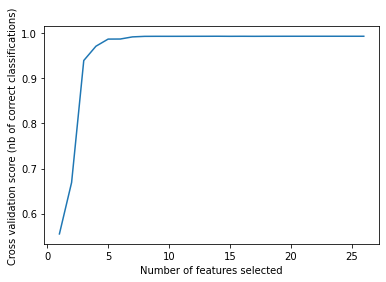

In [9]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [265]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_scaled.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top_features = rfe_ft_imp_df.head(50)

top_features

ValueError: arrays must all be same length

### Embedded method for feature selection
- 26 features are selected based on the weight distribution from the Recurvesive features selection result. 
- Embedded method is utilized to reduce the number of features further down with Lasso regularization method.
- LASSO regularization method penalizes coefficients of features and remove those that are with coefficient=0.
- A total of 7 features are selected : 
    - deposit_type,
    - lead_time,
    - market_segment,
    - distribution_channel,
    - total_of_special_requests,
    - required_car_parking_spaces,
    - previous_bookings_not_canceled,
    - adr

In [277]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_sel, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_sel,y))
coef = pd.Series(reg.coef_, index = X_sel.columns)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.90659589695133, tolerance: 2.1639201430186996
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.35132674051965, tolerance: 2.1639201430186996
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.42640650375324, tolerance: 2.1639201430186996
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.558551579959385, tolerance: 2.37457557165593
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.50823672259503, tolerance: 2.37457557165593
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.33793961267475, tolerance: 2.37457557165593
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: Conv

Best alpha using built-in LassoCV: 0.056059
Best score using built-in LassoCV: 0.232606


In [278]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 19 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

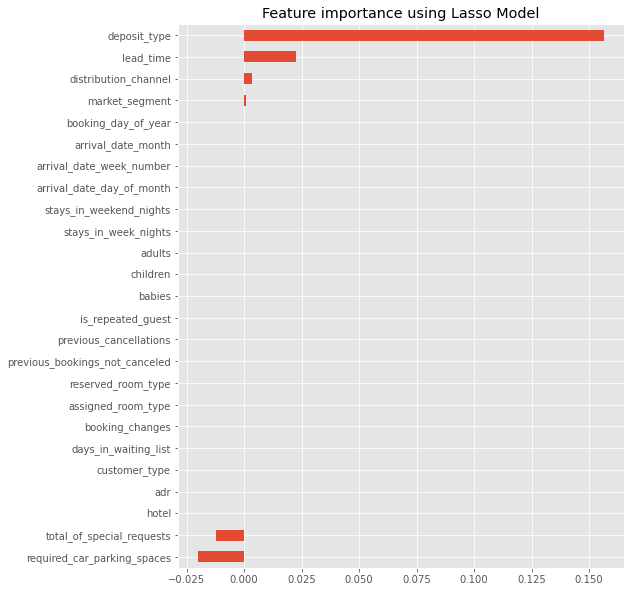

In [279]:
# Visualizing the feature importance using LASSO 

import matplotlib.pyplot as plt
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Text(0.5, 1.0, 'Feature importance using Lasso Model')

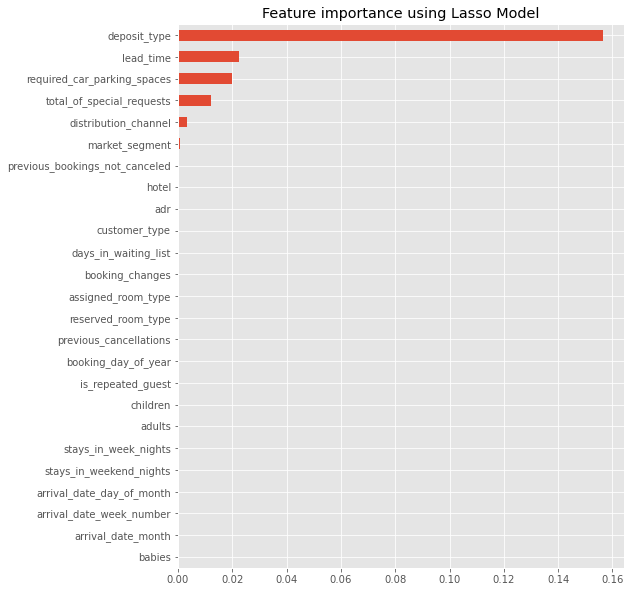

In [280]:
imp_coef = coef.sort_values()
abs_imp_coef = abs(imp_coef)
abs_imp_coef=abs_imp_coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
abs_imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")



## Cross Validation
- We applied the feature selection from above and decided to use 80:20 training/test split along with using gridSearch. 
- We will be using gridSearch function, which has 5 fold cross validation. 

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

X_sel = X_scaled[[
'deposit_type',
'lead_time',
'market_segment',
'distribution_channel',
'total_of_special_requests',
'required_car_parking_spaces',
'previous_bookings_not_canceled',
'adr'
]]

X_train, X_test, y_train, y_test = train_test_split(X_sel, y,test_size=0.2,random_state=10)

# Build Model<a id='Build-Model'/>

## Logistic Regression 


### Adjusting Parameter
- We used GridSearchCV to provide various parameters to adjust the model. GridSearchCV will run multiple computation to find the estimator with the best parameters that result the highest accuracy based on the scoring metric we provide.
- For penalization, we set penalty param for l1 and l2.
- For regularization, logistic regression has C parameter which is inversion of regularization. We provide C from 0.001 to 1000. Then we also 
- For class weight, we used balanced and none. Balanced mode uses value of target to adjust weights inversely proportional to the class frequencies. 
- For solver param, which is algorithm to used in optimization problem, we used lbfgs which is default and saga which is good fit for the large data set.

Doing f1 scoring, which is best for a binary target like is_canceled

### SGD classifier method (Logistic regression)

In [12]:
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameters =  [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1],
    'random_state':[10]
}]

log_estimator = SGDClassifier()

logGridSearch = GridSearchCV(estimator=log_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

logGridSearch.fit(X_train, y_train)

means = logGridSearch.cv_results_['mean_test_score']
stds = logGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, logGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    6.8s finished


              precision    recall  f1-score   support

           0       0.77      0.93      0.84     15017
           1       0.82      0.52      0.64      8861

    accuracy                           0.78     23878
   macro avg       0.79      0.73      0.74     23878
weighted avg       0.79      0.78      0.77     23878



In [13]:
logGridSearch.best_params_

{'alpha': 0.0001,
 'loss': 'log',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 10}

### GridSearch method (Logistic regression)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
regEstimator = LogisticRegression()


tuning_parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [10] 
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }


#Doing f1 for accuracy best for binary

#Create a grid search object using the  

from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuning_parameters
                   , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)

means = regGridSearch.cv_results_['mean_test_score']
stds = regGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, regGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    8.7s finished


              precision    recall  f1-score   support

           0       0.80      0.79      0.80     15017
           1       0.66      0.67      0.67      8861

    accuracy                           0.75     23878
   macro avg       0.73      0.73      0.73     23878
weighted avg       0.75      0.75      0.75     23878



In [15]:
 regGridSearch.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'random_state': 10,
 'solver': 'lbfgs'}

In [16]:
regGridSearch.best_score_

0.6650343832257734

In [17]:
 regGridSearch.best_estimator_.intercept_

array([-0.10307943])

In [18]:
regGridSearch.best_estimator_.coef_

array([[ 1.10448675,  0.35074875,  0.45329129, -0.0518891 , -0.4342493 ,
        -0.71340819, -0.04447618,  0.23996118]])

In [19]:
log_coefficients = pd.concat([pd.DataFrame(X_test.columns),pd.DataFrame(np.transpose(regGridSearch.best_estimator_.coef_))], axis = 1)
log_coefficients

,0,0
0,deposit_type,1.104487
1,lead_time,0.350749
2,market_segment,0.453291
3,distribution_channel,-0.051889
4,total_of_special_requests,-0.434249
5,required_car_parking_spaces,-0.713408
6,previous_bookings_not_canceled,-0.044476
7,adr,0.239961


### `Given the coefficients of each feature, why do you think some features are more important?` <a id='question1'/> 

- The intercept is -0.10307943 which corresponds to the log odds for hotel booking being canceled
- Most important feature, deposit_type, is categorical variable and it has coefficient of 1.104487 which gives odd ratio of 3.0177.
    - For every 1 unit increase in deposit type (0 = No Deposit, 1 = Non Refund, 2 = Refundable), the odds will increase by a multiplicative factor of 3.0177 holding all other features employed in the model fixed.
- Second important feature, lead_time, is continuous variable and it has coefficient of 0.350749 which gives odd ratio of 1.4201.
    - For every 1 unit increase  in lead_time, the odds will increase by a multiplicative factor of 1.4201 holding all other features employed in the model fixed.

## Support Vector Machines

### Adjusting  Parameter
 - Parameters for Non-linear SVM are Gamma(controls the size of the radial basis function kernel) and C(margin hardness).
 - The algorithm allows the margin to be flexible in terms of  allowing some support vectors creep into the margin based on the tuned parameter C(margin hardness). 
 - Gamma defines how far the influence of a single training example reaches. For example, for a high gamma value, a group of points near the boundary will have a higher weight and thus result in curvy boundary

### SGD classifier method (SVM)

In [30]:
from sklearn.metrics import classification_report

tuned_parameters =  [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['hinge'], # svm,
    'penalty': ['l2'],
    'n_jobs': [-1],
    'random_state':[10]
}]

svm_estimator = SGDClassifier()

svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

svmGridSearch.fit(X_train, y_train)

means = svmGridSearch.cv_results_['mean_test_score']
stds = svmGridSearch.cv_results_['std_test_score']

y_true, y_pred = y_test, svmGridSearch.predict(X_test)
print(classification_report(y_true, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    5.4s finished


              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15017
           1       0.99      0.33      0.50      8861

    accuracy                           0.75     23878
   macro avg       0.85      0.67      0.67     23878
weighted avg       0.82      0.75      0.71     23878



In [31]:
svmGridSearch.best_params_

{'alpha': 0.0001,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 10}

In [32]:
svmGridSearch.best_estimator_

SGDClassifier(n_jobs=-1, random_state=10)

In [33]:
svmGridSearch.best_estimator_.coef_

array([[ 0.71778907,  0.04325649,  0.02793275,  0.02250937, -0.02656358,
        -1.05204784, -0.04365302,  0.05486753]])

#### Downsampling data
- For the execution of GridSearch method, we decided to downsample our data (3% of the original data) due to a computational issue

In [42]:

X_downsample = X_sel


X_downsample.loc[:,'target'] = y

/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [43]:
X_sample=X_downsample.sample(frac=0.03, replace=False, random_state=10)
y_sample=X_sample.target
X_sample.drop("target",axis=1,inplace=True)

In [44]:
from sklearn.model_selection import train_test_split
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample,test_size=0.2,random_state=10)

### GridSearch method (SVM)
- This method explores optimal parameters of gamma and C for both linear and non-linear kernel SVMs. 

In [69]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score


svm_estimator = SVC()


tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'random_state': [10]},
    {'kernel': ['linear'], 'C': [100], 'random_state': [10]}]


svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , scoring='f1')

svmGridSearch.fit(X_sample_train, y_sample_train)

means = svmGridSearch.cv_results_['mean_test_score']
stds = svmGridSearch.cv_results_['std_test_score']


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  2.5min finished


In [71]:
y_true, y_pred = y_sample_test, svmGridSearch.predict(X_sample_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       444
           1       0.99      0.29      0.45       273

    accuracy                           0.73       717
   macro avg       0.84      0.64      0.63       717
weighted avg       0.81      0.73      0.68       717



In [72]:
svmGridSearch.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 10}

In [47]:
# Support vector positions

len(svmGridSearch.best_estimator_.support_vectors_)

1410

In [51]:
# SVM coefficients
svm_coefficients = pd.concat([pd.DataFrame(X_sample_test.columns),pd.DataFrame(np.transpose(svmGridSearch.best_estimator_.support_vectors_))], axis = 1)
svm_coefficients

,0,0,1,2,3,4,5,6,7,8,...,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409
0,deposit_type,-0.373175,-0.373175,-0.373175,-0.373175,-0.373175,-0.373175,-0.373175,-0.373175,-0.373175,...,-0.373175,2.614780,-0.373175,-0.373175,-0.373175,2.614780,2.614780,-0.373175,-0.373175,-0.373175
1,lead_time,0.963747,1.019894,1.197692,0.112187,-0.954603,1.328702,-0.421208,0.196407,-0.664511,...,-0.935887,4.847237,1.974390,0.439710,-0.907814,-0.617722,0.084113,-0.589649,0.355490,1.506500
2,market_segment,0.846227,-0.732679,0.846227,0.056774,0.846227,0.056774,0.846227,0.846227,0.846227,...,0.846227,-0.732679,0.846227,0.846227,0.846227,-2.311586,-2.311586,-0.732679,0.846227,-0.732679
3,distribution_channel,0.456981,0.456981,0.456981,0.456981,0.456981,0.456981,0.456981,0.456981,0.456981,...,0.456981,0.456981,0.456981,0.456981,0.456981,-2.848688,0.456981,0.456981,0.456981,0.456981
4,total_of_special_requests,0.540666,-0.720694,0.540666,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694,0.540666,...,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694,-0.720694
5,required_car_parking_spaces,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,...,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873,-0.254873
6,previous_bookings_not_canceled,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,...,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555,-0.091555
7,adr,-0.056022,0.042918,-0.698540,-0.293479,1.335670,-1.195813,1.309352,1.493381,0.763202,...,0.137900,-0.788180,1.052108,0.047865,-0.273691,-0.530935,-0.036234,0.557407,-0.323161,-0.772349


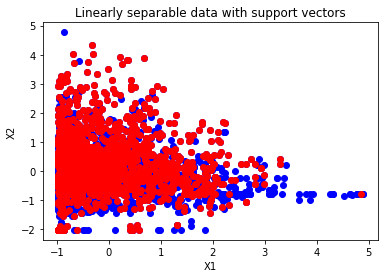

In [49]:
import matplotlib.pyplot as plt
support_vectors = svmGridSearch.best_estimator_.support_vectors_

# Visualize support vectors
plt.scatter(X_sample_train['lead_time'], X_sample_train['adr'], color='blue')
plt.scatter(support_vectors[:,1], support_vectors[:,7], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### `Do the chosen support vectors provide any insight into the data?`   <a id='question2'/> 

- The goal of SVM is to find the hyperplane in which the margin is maximized between the separated dataset. 
- Support vectors are the points closest to the hyperplane and gives us an idea on how separable the data is.
- The optimal parameter setting that the GridSearch method suggested showed too many support vector points in relation to the training dataset. Also it is clear that there is no linearity between the dependent features and the target feature. 

### So how can we fix this problem?<a id='question3'/> 
- We are going to experiment with the non-linear kernel SVM with adjusting different parameters. Depending on how much slack we allow the support vectors to enter the margin area, the number of support vectors can vary. The accuracy depends too on finding the right level of slack for the data. 
- Higher C is recommended as higher C results in a smaller margin so that we can minimize the number of misclassified support vectors with a high penalty. 
- Gamma is going to stay the same throughout the experiment.

### Result : 
- Gamma 0.1 and C of 100 resulted in the highest accuracy of 78.8%. The resulting SVM plot shows separation of the data a bit better than the previous plot. 

#### RBF SVM with Gamma= 0.1, C=10

In [58]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=10)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_sample_test)

In [64]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_sample_test, y_pred))

Accuracy for non-linear SVM: 0.7852161785216178


#### RBF SVM with Gamma= 0.1, C=100

In [65]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=100)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_sample_test)

In [66]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_sample_test, y_pred))

Accuracy for non-linear SVM: 0.7880055788005579


In [74]:
rbf.support_vectors_

array([[-0.37317536,  0.96374724,  0.84622724, ..., -0.25487288,
        -0.09155477, -0.05602234],
       [-0.37317536,  1.01989408, -0.73267928, ..., -0.25487288,
        -0.09155477,  0.04291785],
       [-0.37317536, -0.45863935, -0.73267928, ..., -0.25487288,
        -0.09155477, -0.53093528],
       ...,
       [-0.37317536, -0.90781407,  0.84622724, ..., -0.25487288,
        -0.09155477, -0.27369077],
       [-0.37317536, -0.58964864, -0.73267928, ..., -0.25487288,
        -0.09155477,  0.55740687],
       [-0.37317536,  1.50650002, -0.73267928, ..., -0.25487288,
        -0.09155477, -0.77234935]])

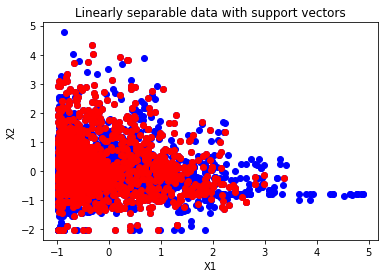

In [75]:
import matplotlib.pyplot as plt
support_vectors = rbf.support_vectors_

# Visualize support vectors
plt.scatter(X_sample_train['lead_time'], X_sample_train['adr'], color='blue')
plt.scatter(support_vectors[:,1], support_vectors[:,7], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#### RBF SVM with Gamma= 0.1, C=1000

In [67]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=1000)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_sample_test)

In [68]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_sample_test, y_pred))

Accuracy for non-linear SVM: 0.7852161785216178


# Assess Model<a id='Assess-Model'/>

### Does one type of model offer superior performance over another in terms of prediction accuracy?<a id='question4'/> 
- We used SDG Classifier, stochastic gradient descent, and LogisticRegression classifiers to predict. SDG Classifier with logistic regression had prediction with the highest accuracy, 0.77, while SDG Classifier with SVM and LogisticRegression had 0.75 accuracy. Although we used both logistic for loss function, SDG Classifier had better accuracy than LogisticRegression model.

### In terms of training time or efficiency?  <a id='question5'/> 

#### Logistic regression 
- It took about 11.1 seconds to process the data with LogisticRegression Classifier.

#### Linear SVM
- It took about 20 mins for the gridSearch CV for the linear SVM to process the data. 

#### Stochastic Gradient Descent
- It took about 3.2 seconds to process the data with logistic regression loss function
- It took about 2.4 seconds to process the data with linear SVM loss function

### Best Model for efficiency and Accuracy
- For both Computation performance and Accuracy, **SDG Classifier with logistic regression** had better results.